In [15]:
import torch  #type: ignore
import torch.nn.functional as F #type: ignore
import matplotlib.pyplot as plt  #type: ignore
%matplotlib inline

In [16]:
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [18]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [19]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [8]:
# build the dataset
block_size = 8 # changing the context size in this case

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [9]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [24]:
#the apis for the layers

#linear layer
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / (fan_in)**0.5  #kaiming init
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if not self.bias is None:
            self.out += self.bias
        print("linear layer: ", self.out.shape)
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
#batchnorm layer
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True  # by default
        #training params
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        #buffers, to record the mean, var of samples passing through all the neurons
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):  #where x is the batch of samples
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / (xvar + self.eps).sqrt()
        self.out = self.gamma * xhat + self.beta
        if self.training:  #capture the running mean, var
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
            self.running_vat = (1 - self.momentum) * self.running_var + self.momentum * xvar

        print("batch norm layer: ", self.out.shape)
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

#tanh layer
class Tanh:
    def __call__(self, x):
        self.out = x.tanh()
        print("tanh layer", self.out.shape)
        return self.out
    
    def parameters(self):
        return []
    
#embedding layer
class Embedding:
    def __init__(self, num_embedding, embedding_dim):
        self.weight = torch.randn((num_embedding, embedding_dim))  #its not actually a weight
        #matrix, but a lookup table, but its named this way as we want consistency bw the APIS

    def __call__(self, ix):
        self.out = self.weight[ix]
        print("embedding layer: ", self.out.shape)
        return self.out
    
    def parameters(self):
        return [self.weight]
    
#flattening layer
class FlattenConsecutive:
    def __init__(self, n):  #n is context size of a patch
        self.n = n

    def __call__(self, x):
        self.out = x.view(x.shape[0], x.shape[1]//self.n, x.shape[2]*self.n)   #flattening it based on patches of input, in this
        #case we take a bigram in a patch, and since we have 8 as context, there are 4 bigrams obtained
        if self.out.shape[1] == 1:
            self.out = self.out.squeeze(1)  #if there is only one patch, then squeeze that dim
        print("flattening layer: ", self.out.shape)
        return self.out
    
    def parameters(self):
        return []
    
#sequential API, which strings the layers in a set manner, and gives the final output when called 
#in that sequence
class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):  #this x is the batch of samples to the first layer
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [25]:
#not mentioning the generator, but doing it as a whole here
torch.manual_seed(42);  #seed random num generator for reproducibility

In [26]:
# defining the heirarchical wavenet like model
n_embed = 24
n_hidden = 128
context_per_pool = 2

model = Sequential([  #creating instances of the layer classes here
    Embedding(vocab_size, n_embed),  

    FlattenConsecutive(context_per_pool), 
    Linear(n_embed * context_per_pool, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),

    FlattenConsecutive(context_per_pool), 
    Linear(n_hidden * context_per_pool, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),

    FlattenConsecutive(context_per_pool), 
    Linear(n_hidden * context_per_pool, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    
    Linear(n_hidden, vocab_size)
])

#specific initialisation of the param
with torch.no_grad():
    model.layers[-1].weight *= 0.1   #make the last layers output less confidently wrong initially

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


76579


In [27]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    #making the minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    #forawrd pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad
    
    #track stats
    if i % 10000 == 0:
        print(f"{i: 7d}/{max_steps: 7d}: {loss.item(): .4f}")
    lossi.append(loss.log10().item())

    break

embedding layer:  torch.Size([32, 8, 24])
flattening layer:  torch.Size([32, 4, 48])
linear layer:  torch.Size([32, 4, 128])
batch norm layer:  torch.Size([32, 4, 128])
tanh layer torch.Size([32, 4, 128])
flattening layer:  torch.Size([32, 2, 256])
linear layer:  torch.Size([32, 2, 128])
batch norm layer:  torch.Size([32, 2, 128])
tanh layer torch.Size([32, 2, 128])
flattening layer:  torch.Size([32, 256])
linear layer:  torch.Size([32, 128])
batch norm layer:  torch.Size([32, 128])
tanh layer torch.Size([32, 128])
linear layer:  torch.Size([32, 27])
      0/ 200000:  3.3167


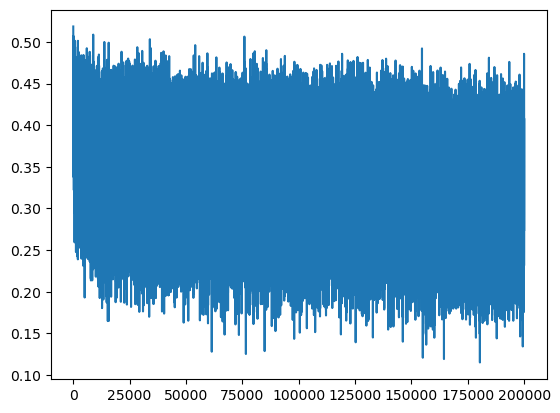

In [50]:
plt.plot(lossi)

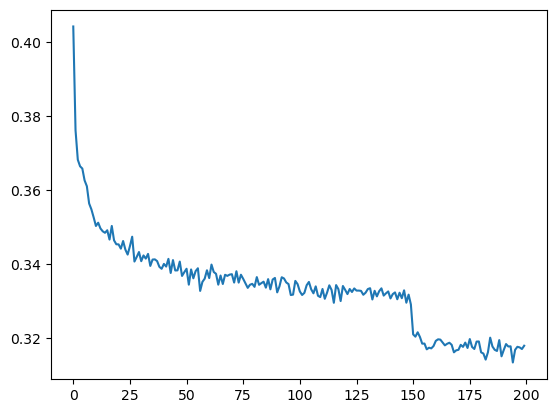

In [51]:
#a better plot of the losses where we take the avgs of 1000 loss values, show that
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1));

In [52]:
#evaluating the loss, so putting the layers in eval mode 
for layer in model.layers:
    layer.training = False
#this is important, only for batchnorm layers, as they need to have a batch of diff smaples for
#them to work, but during testing we only pass in one sample, so we need to make the layer know
#

In [53]:
#evaluate the loss
@torch.no_grad
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'test': (Xte, Yte),
        'val': (Xdev, Ydev)
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(f"{split} loss: {loss}")

split_loss('train')
split_loss('test')
split_loss('val')
    

train loss: 2.2515878677368164
test loss: 2.3235023021698
val loss: 2.3217737674713135


In [ ]:
#this is not that different from the prev model, but we just introduced the hierarchical structure
#and also used the input layer as pools of bigrams(or n-grams for that matter) which made it
#such that not the whole context is squished into one big vector, but rather the context is
#used and learned from gradually and in a hierarchical manner, and this is achieved by pooling which 
#is just another way of saying convolutions.

In [14]:
torch.backends.mps.is_available()  #just to chk if MPS is available

True

In [21]:
x = torch.randn((1, 2), device='mps')

tensor([[-1.5057, -0.4483]], device='mps:0')

In [22]:
y = torch.randn((2, 3, 89), device='mps')